# Сети с радиальными базисными элементами.

Импорт необходимых библиотек.

In [1]:
import numpy as np
import pandas as pd
import math as mh
import random as rd
import seaborn as sb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend
from keras.models import load_model

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10,10)
from mpl_toolkits.mplot3d import Axes3D

# I. RBF (вероятностная) сеть для классификации точек в случае, когда классы не являются линейно разделимыми.

Аналогично предыдущей лабораторной работе, заданы 3 линейно неразделимых класса. Точки, принадлежащие одному классу, лежат на алгебраической линии. Необходимо обучить сеть для классификации точек в заданной области. В моем варианте все три класса представлены эллипсами, соответсвенно, сгенерируем множество точек для каждого эллипса.

In [2]:
class Ellipse(object):
    def __init__(self, a, b, alpha = 0, x0 = 0, y0 = 0):
        self.a = a
        self.b = b
        self.alpha = alpha
        self.x0 = x0
        self.y0 = y0
        self.x, self.y = np.array([]), np.array([])
        self.dim = 0
        
    def f(self, t):
        x = self.a * np.cos(t)
        y = self.b * np.sin(t)
        return x * mh.cos(self.alpha) + y * mh.sin(self.alpha) - self.x0
    
    def g(self, t):
        x = self.a * np.cos(t)
        y = self.b * np.sin(t)
        return - x * mh.sin(self.alpha) + y * mh.cos(self.alpha) - self.y0

    def points_gen(self, start, stop, step):
        t = np.arange(start, stop, step)
        self.x = self.f(t)
        self.y = self.g(t)
        self.dim = np.size(t)

    def show(self, color='blue'):
        print("Эллипс построен!")
        
        plt.plot(self.x, self.y, color=color)
        plt.title('Эллипс')
        plt.ylabel('x')
        plt.xlabel('y')
        plt.grid()
        plt.show()

Зададим параметры для генерации точек.

In [3]:
start = 0
step = 0.025
stop = 2 * mh.pi

Создадим три эллипса согласно варианту и сгенерируем для них точки.

Эллипс построен!


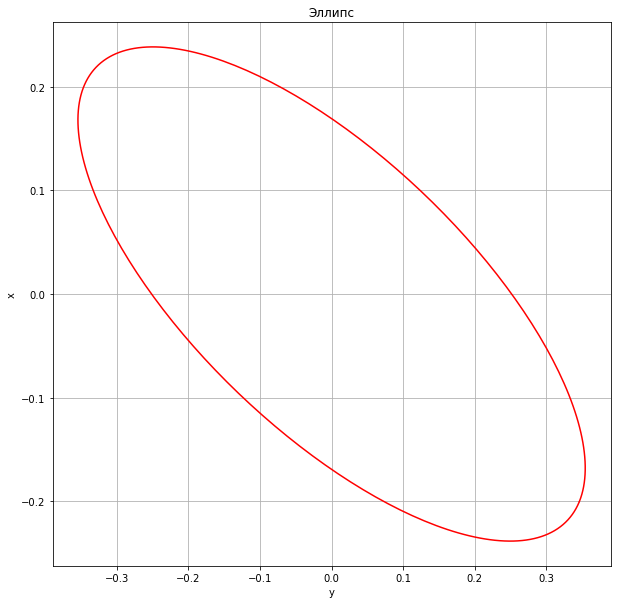

In [4]:
a, b, alpha = 0.4, 0.15, mh.pi/ 6
line1 = Ellipse(a, b, alpha)
line1.points_gen(start, stop, step)
line1.show('red')

Эллипс построен!


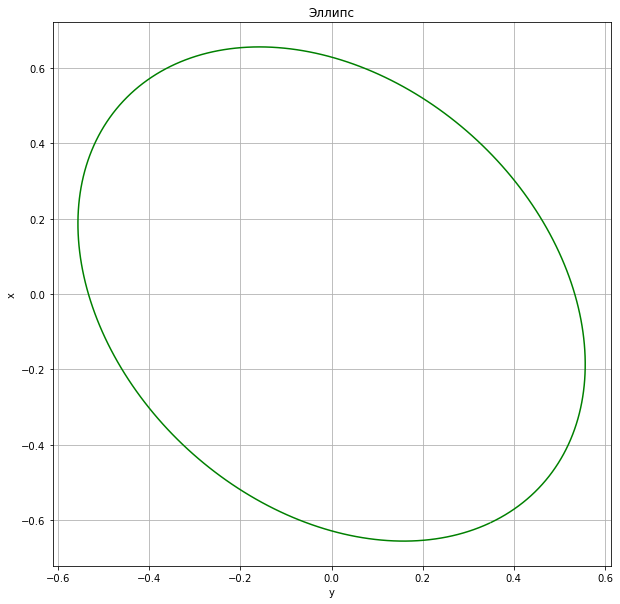

In [5]:
a, b, alpha = 0.7, 0.5, mh.pi/ 3
line2 = Ellipse(a, b, alpha)
line2.points_gen(start, stop, step)
line2.show('green')

Эллипс построен!


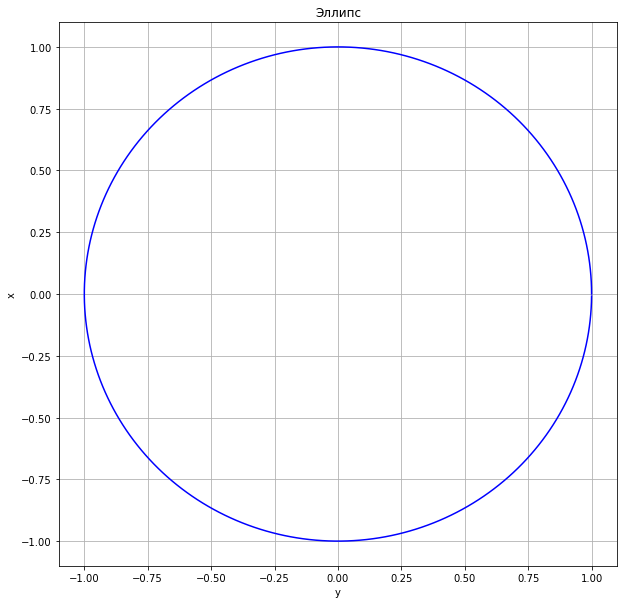

In [6]:
a, b = 1, 1
line3 = Ellipse(a, b)
line3.points_gen(start, stop, step)
line3.show('blue')

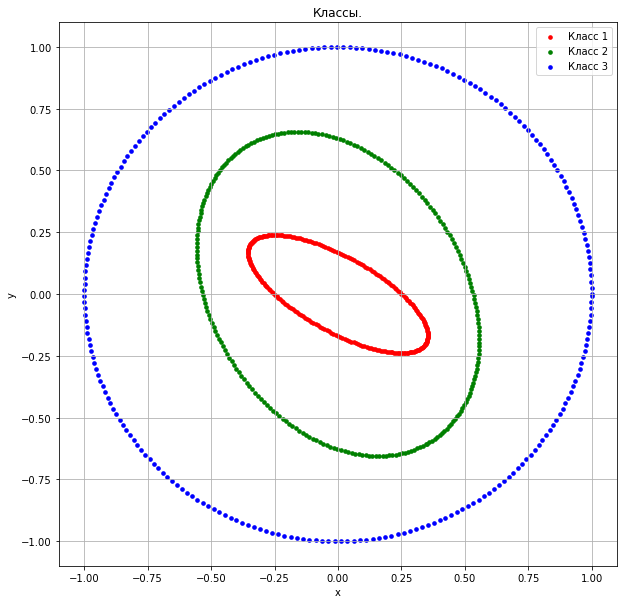

In [7]:
plt.scatter(line1.x, line1.y, color='r', linewidth=2, s=7)
plt.scatter(line2.x, line2.y, color='g', linewidth=2, s=7)
plt.scatter(line3.x, line3.y, color='b', linewidth=2, s=7)


plt.title('Классы.')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Класс 1', 'Класс 2', 'Класс 3'], loc='upper right')
plt.grid()
plt.show()

# Работа с данными

Для формирования обучающей выборки выберем из первого класса 60 точек рандомным образом,из второго и третьего классов - 100 и 120 точек соответственно.

In [8]:
r = np.array([[line1.x[i], line1.y[i]] for i in np.random.permutation(line1.dim)[:100]])
g = np.array([[line2.x[i], line2.y[i]] for i in np.random.permutation(line2.dim)[:120]])
b = np.array([[line3.x[i], line3.y[i]] for i in np.random.permutation(line3.dim)[:150]])

Теперь разделим множества точек каждого класса на обучающее и тестовое подмножества в соотношении 80 : 20. Чтобы модель обучалась на разнородных данных, сначала перемешаем полученные точки.

In [9]:
np.random.shuffle(r)
np.random.shuffle(g)
np.random.shuffle(b)

r_train, r_test = np.array_split(r, [ int( 0.8 * np.shape(r)[0])])
g_train, g_test = np.array_split(g, [ int( 0.8 * np.shape(g)[0])])
b_train, b_test = np.array_split(b, [ int( 0.8 * np.shape(b)[0])])

Отобразим полученные выборки для каждого класса.

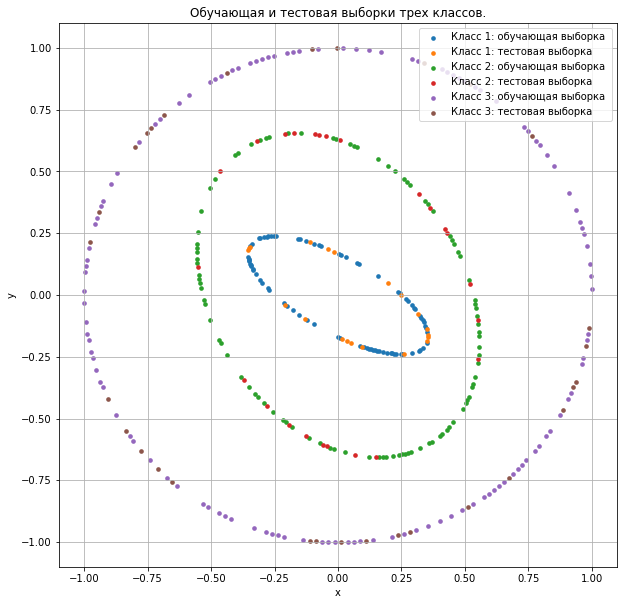

In [10]:
plt.scatter(r_train[:,0], r_train[:,1], linewidth=2, s=7)
plt.scatter(r_test[:,0], r_test[:,1], linewidth=2, s=7)

plt.scatter(g_train[:,0], g_train[:,1], linewidth=2, s=7)
plt.scatter(g_test[:,0], g_test[:,1], linewidth=2, s=7)

plt.scatter(b_train[:,0], b_train[:,1], linewidth=2, s=7)
plt.scatter(b_test[:,0], b_test[:,1], linewidth=2, s=7)

plt.title('Обучающая и тестовая выборки трех классов.')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Класс 1: обучающая выборка ', 'Класс 1: тестовая выборка',
           'Класс 2: обучающая выборка ', 'Класс 2: тестовая выборка',
           'Класс 3: обучающая выборка ', 'Класс 3: тестовая выборка'], loc='upper right')
plt.grid()
plt.show()

Согласно построенному изображению, классы не пересекаются, т.е. нет точек, принадлежащих одному и тому же классу.

Теперь, когда подмножества для всех классов сформированы, сгенерируем выходные значения для каждой точки каждого класса. Далее, объединим полученные входные и выходные выборки в три общие выборки - тренировочное и тестовое подмножества.

Генерация входов и выходов сети множества тренировочных точек.

In [11]:
def data_gen(r, g, b):
    #train_X, train_Y = np.empty((0,2)), np.empty((0,3))
    X, Y = [], []
    classes = np.vstack((r, g, b))
    np.random.shuffle(classes)

    for i in classes:
        j = list(i)
        
        if j in X:
            continue
        #t = np.zeros(3)
        t = [0, 0, 0]
        if i in r:
            t[0] += 1
        if i in g:
            t[1] += 1
        if i in b:
            t[2] += 1
        #train_X = np.append(train_X, [i], axis=0)
        X.append(j)
        #train_Y = np.append(train_Y, [t], axis=0)
        Y.append(t)
    return np.array(X), np.array(Y)

Формирование обучающей, валидационной и тестовой выборок.

In [12]:
train_X, train_Y = data_gen(r_train, g_train, b_train)
test_X, test_Y = data_gen(r_test, g_test, b_test)

# Конструирование и обучение сети

Т.к. сеть с радиальными базисными элементами двухслойная, но при обучении меняются весовые коэффициенты только между выходным и скрытым слоем, сконструируем сеть самостоятельно без использования библиотек.

In [13]:
class RBF(object):
    def __init__(self, neurons1, neurons2, const_weights):
        self.layers = 2
        self.neurons = np.array([neurons1, neurons2])
        if neurons1 > 1:
            self.weights = np.array([const_weights.transpose(), np.array([[rd.random() for i in range(neurons1)] for j in range(neurons2)]).transpose()])
            self.beta = np.array([rd.random() for i in range(neurons2)])
        else:
            self.weights = np.array([const_weights.transpose(), np.array([rd.random() for i in range(neurons1)]).transpose()])
            self.beta = rd.random()
    def show(self):
        print("The network consists of:")
        print("\t ", self.layers, "hidden layer with ", self.neurons[0], " neuron(s), out layer with ", self.neurons[1], " neuron(s).")
        print("Hidden layer constant weights: ")
        print(self.weights[0])
        print("Out layer weights: ")
        print(self.weights[1])

Сконструируем сеть.
Весовые коэффициенты скрытого слоя будут соответствовать всей выборке точек. Для этого объединим их.

In [14]:
const_weights = np.vstack((r, g, b))
n1 = np.shape(const_weights)[0]
n2 = 3

rbf = RBF(n1, n2, const_weights)
rbf.show()

The network consists of:
	  2 hidden layer with  370  neuron(s), out layer with  3  neuron(s).
Hidden layer constant weights: 
[[-1.54360414e-01 -3.49315382e-01 -2.52021287e-01  2.93247203e-01
   3.52224000e-01  2.54107629e-01  1.12971526e-01  3.36286855e-01
   3.34524700e-01 -1.59250236e-01  8.74813037e-02 -3.33528180e-01
  -3.36421973e-01 -3.51879146e-01  1.29620845e-01  1.45946180e-01
  -2.98363462e-01 -1.26842848e-01 -2.72182467e-01  2.74081528e-01
   2.68378176e-01 -9.64522419e-02 -1.77833385e-01 -9.31680878e-02
  -1.21736628e-01 -2.81126286e-01 -1.51285161e-01  3.48271263e-01
  -3.23604018e-01  1.21334100e-01 -2.75642647e-01  3.28252829e-01
   3.19407764e-03 -3.45878512e-01 -3.41577125e-01  2.47851575e-01
   8.21873220e-02 -2.14253183e-04  3.37347982e-01  3.44546441e-01
  -3.53563396e-01  8.64579347e-03  2.43924693e-01  1.37826581e-01
  -3.10226381e-01 -3.07552718e-01  2.28170139e-01 -7.59601858e-02
  -3.43835261e-01 -2.64162101e-01 -3.47028462e-01  2.07205848e-01
  -2.14670477e-

Гауссиан - функция активации скрытого слоя, находится от квадрата расстояния между двумя точками.

In [15]:
def gaussian(x):
    return np.exp(-x)

Функция, которая находит квадрат расстояния между двумя точками.

In [16]:
def dist_count(x, weights):
    if np.shape(weights)[0] == 2:
        return np.array([ (cx - x[0])**2 + (cy - x[1])**2 for cx, cy in zip(weights[0,:], weights[1,:])])
    else:
        return np.array([ (cx - x[0])**2 for cx in weights[0,:]])

In [17]:
def predict(self, X):
    dist = np.array([gaussian(dist_count(x, self.weights[0])) for x in X])
    out = np.array([ d.dot(self.weights[1]) + self.beta for d in dist])
    return out

Среднеквадратичная ошибка.

In [18]:
def multi_loss(out, T):
    return np.sum(np.sum((T - out)**2, axis=1)) / np.shape(T)[0]

Обучение сети.

In [19]:
def multi_train(self, D, X, Y, learning_rate, epochs):
    eps = 1e-5
    mse = 1
    mses = []
    
    for i in range(epochs):
        if mse <= eps:
            break
        for x, y, dist in zip(X, Y, D):
            #dist = dist_count(p, self.weights[0])
            out = dist.dot(self.weights[1]) + self.beta
            e = y - out
            #print(e)
            #print(np.shape(self.weights[1]))
            if e.all() == 0:
                continue
            self.weights[1] += np.array([[ i * j for j in e] for i in dist]) * learning_rate
            self.beta += e * learning_rate
        mse = multi_loss(predict(self, X), Y)
        print("Epoch: ", i + 1, " mse: ", mse)
        mses.append(mse)
        #print(mses)
    return mses

Находим значения скрытого слоя - ищем гауссиан квадратов расстояния между каждым сигналом обучающей выборки и каждой точки всей выборки. После, обучаем сеть.

In [20]:
dist = np.array([gaussian(dist_count(x, rbf.weights[0])) for x in train_X])

mses = multi_train(rbf, dist, train_X, train_Y, 5 * 1e-4, 1500)
print("The model is trained!")

Epoch:  1  mse:  10.800991435715918
Epoch:  2  mse:  6.951324348850337
Epoch:  3  mse:  5.262683228368114
Epoch:  4  mse:  4.083175890520804
Epoch:  5  mse:  3.208794056065307
Epoch:  6  mse:  2.5521938491159917
Epoch:  7  mse:  2.0562102726200004
Epoch:  8  mse:  1.6796648181126352
Epoch:  9  mse:  1.3923198392127567
Epoch:  10  mse:  1.1718689363439432
Epoch:  11  mse:  1.0018104949975655
Epoch:  12  mse:  0.869898129130004
Epoch:  13  mse:  0.7670090738856186
Epoch:  14  mse:  0.6863185795095359
Epoch:  15  mse:  0.6226975090777227
Epoch:  16  mse:  0.5722722380632116
Epoch:  17  mse:  0.532102443656386
Epoch:  18  mse:  0.499944560119745
Epoch:  19  mse:  0.47407756974196424
Epoch:  20  mse:  0.4531742436990135
Epoch:  21  mse:  0.43620560295253474
Epoch:  22  mse:  0.4223697293264283
Epoch:  23  mse:  0.4110384820860444
Epoch:  24  mse:  0.40171742723305465
Epoch:  25  mse:  0.39401555385805515
Epoch:  26  mse:  0.3876222698718483
Epoch:  27  mse:  0.3822898357303256
Epoch:  28  m

Процесс обучения.

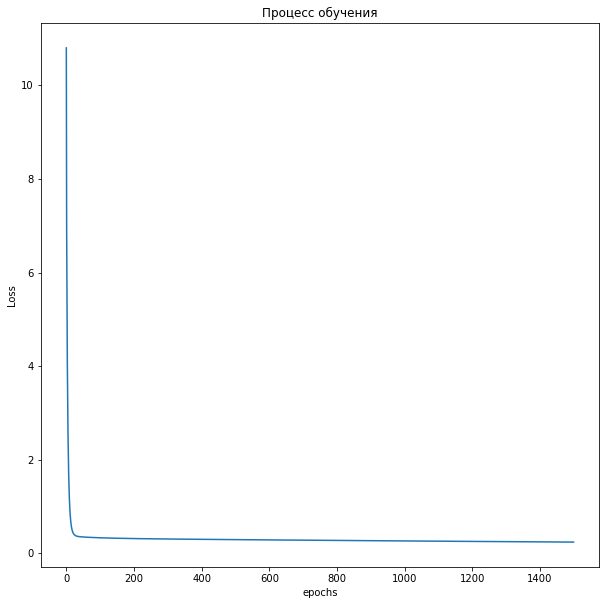

In [21]:
plt.plot(np.array(mses))
plt.title('Процесс обучения')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.show()

# Тестирование сети и обработка результатов

Будем преобразовывать выходные значения согласно правилу.

In [22]:
def check(preds, true):
    correct = 0
    dim = np.shape(preds)[0]
    for p, t in zip(preds, true):
        if np.array_equal(p, t):
            correct += 1
    print("Сеть правильно классифицировала ", correct, " точек из ", dim)
    print("Точность обучения: ", round(correct/ dim * 100, 2), " %")

In [23]:
def transform(preds):
    for i in range(np.shape(preds)[0]):
        for j in range(3):
            if preds[(i, j)] >= 0.5:
                preds[(i, j)] = 1
            else:
                preds[(i, j)] = 0
    return preds

Проверим качество обучения на обучающем множестве.

In [24]:
preds = predict(rbf, train_X)
p = transform(preds)
check(p, train_Y)

Сеть правильно классифицировала  266  точек из  296
Точность обучения:  89.86  %


Проверим качество обучения на тестовом множестве.

In [25]:
preds = predict(rbf, test_X)
p = transform(preds)
check(p, test_Y)

Сеть правильно классифицировала  68  точек из  74
Точность обучения:  91.89  %


# Классификация точек сетки

Теперь, когда мы проверили качество обучения сети на всех трех выборках, будем классифицировать все точки области $[-1.2; 1.2]x[-1.2; 1.2].$

Генерация всех точек сетки заданной области.

In [26]:
image = np.empty((0, 2))
n = np.arange(-1.1, 1.1, 0.025)
for i in n:
    for j in n:
        image = np.vstack((image, np.array([i, j])))

Классификация точек сетки. Округлим выходные значения сети, создадим по ним матрицу  𝑀𝑥𝑁𝑥3  и построим по ней цветовую карту.

In [27]:
preds = predict(rbf, image)
p = np.round(preds, 1)

dimp = int(np.shape(p)[0] ** 0.5)
matrix = np.array( [ [ p[j * dimp + i] for i in range(dimp) ] for j in range(dimp) ])

Построим цветовую карту.

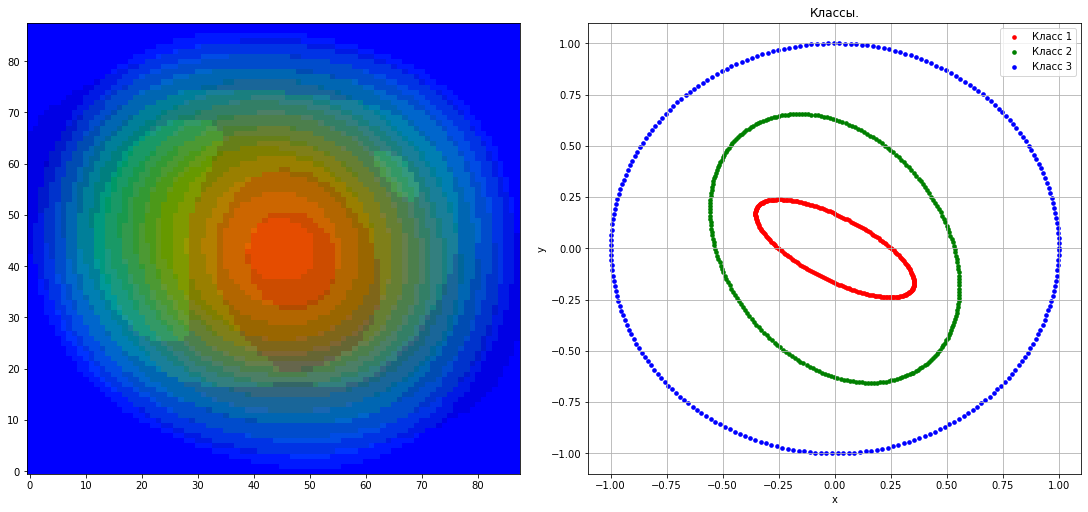

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
p1 = axes[0].imshow(matrix, aspect='auto', origin="lower")

plt.scatter(line1.x, line1.y, color='r', linewidth=2, s=7)
plt.scatter(line2.x, line2.y, color='g', linewidth=2, s=7)
plt.scatter(line3.x, line3.y, color='b', linewidth=2, s=7)


plt.title('Классы.')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Класс 1', 'Класс 2', 'Класс 3'], loc='upper right')
plt.grid()
plt.show()

# II. Обобщенно-регрессионная нейронная сеть для аппроксимации функции. Проверка работы сети с рыхлыми данными.

Будем решать задачу аппроксимации заданной функции. Для этого построим и обучим двухслойную нейронную сеть прямого распространения.

Определим функцию, которую будем аппроксимировать.

In [29]:
def x(t):
    return np.cos(2.5 * t**2 - 5 * t)

Сформируем обучающую выборку.

In [30]:
a, b, h = 0, 2.2, 0.01
T = np.vstack(np.arange(a, b, h))
X = x(T)

Разделим обучающую выборку на обучающее и тестовое подможество. В качестве тестого подмножества возьмем 10% с конца временного ряда.

In [31]:
train_T, test_T =  np.array_split(T, [ int( 0.9 * np.shape(T)[0])])
train_X, test_X =  np.array_split(X, [ int( 0.9 * np.shape(X)[0])])

train_T, test_T = np.vstack(train_T), np.vstack(test_T)
train_X, test_X = np.vstack(train_X), np.vstack(test_X)

Визуализируем выборки.

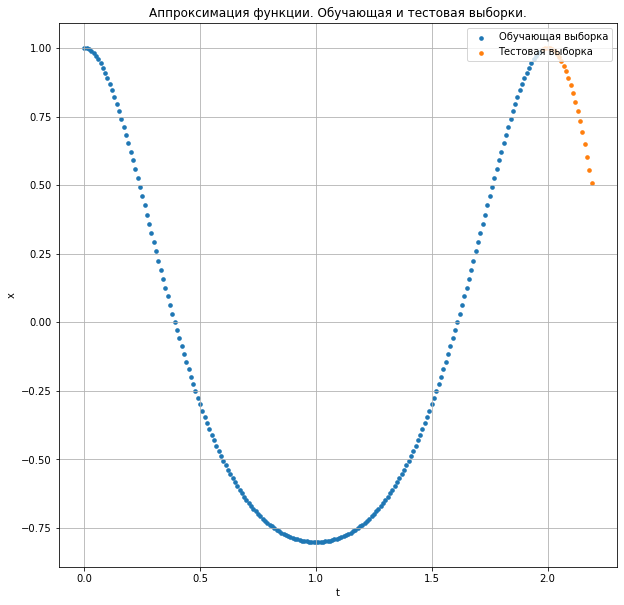

In [32]:
plt.scatter(train_T, train_X, linewidth=2, s=7)
plt.scatter(test_T, test_X, linewidth=2, s=7)

plt.title('Аппроксимация функции. Обучающая и тестовая выборки.')
plt.ylabel('x')
plt.xlabel('t')
plt.legend(['Обучающая выборка', 'Тестовая выборка'], loc='upper right')
plt.grid()
plt.show()

# Конструирование и обучение сети

Сконструируем сеть.

In [33]:
n1 = np.shape(T)[0]
n2 = 1

rbf = RBF(n1, n2, T)
rbf.show()

The network consists of:
	  2 hidden layer with  220  neuron(s), out layer with  1  neuron(s).
Hidden layer constant weights: 
[[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
  0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
  0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
  0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
  0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
  0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
  0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
  0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
  1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
  1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
  1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
  1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
  1.68 1.

Обучим сеть.

In [34]:
dist = np.array([gaussian(dist_count(t, rbf.weights[0])) for t in train_T])

mses = multi_train(rbf, dist, train_T, train_X, 1e-2, 500)
print("The model is trained!")

Epoch:  1  mse:  1074.4901341387767
Epoch:  2  mse:  73.09007474969992
Epoch:  3  mse:  5.032386220665904
Epoch:  4  mse:  2.1590008172194946
Epoch:  5  mse:  2.147783528327875
Epoch:  6  mse:  1.8632343662886912
Epoch:  7  mse:  1.5049642992961216
Epoch:  8  mse:  1.1861590975521197
Epoch:  9  mse:  0.9274967931134269
Epoch:  10  mse:  0.7235333180930944
Epoch:  11  mse:  0.5642241935167863
Epoch:  12  mse:  0.4402397176294613
Epoch:  13  mse:  0.3439183466078986
Epoch:  14  mse:  0.2691831162831379
Epoch:  15  mse:  0.21126616807118867
Epoch:  16  mse:  0.16644044072849712
Epoch:  17  mse:  0.13179658349463108
Epoch:  18  mse:  0.10506519370397222
Epoch:  19  mse:  0.08447700355578729
Epoch:  20  mse:  0.06865337458283893
Epoch:  21  mse:  0.05652065230706509
Epoch:  22  mse:  0.047243219569409536
Epoch:  23  mse:  0.040171181433904884
Epoch:  24  mse:  0.034799492936370045
Epoch:  25  mse:  0.030736033688680345
Epoch:  26  mse:  0.027676676688658027
Epoch:  27  mse:  0.0253858240883

Визуализируем процесс обучения.

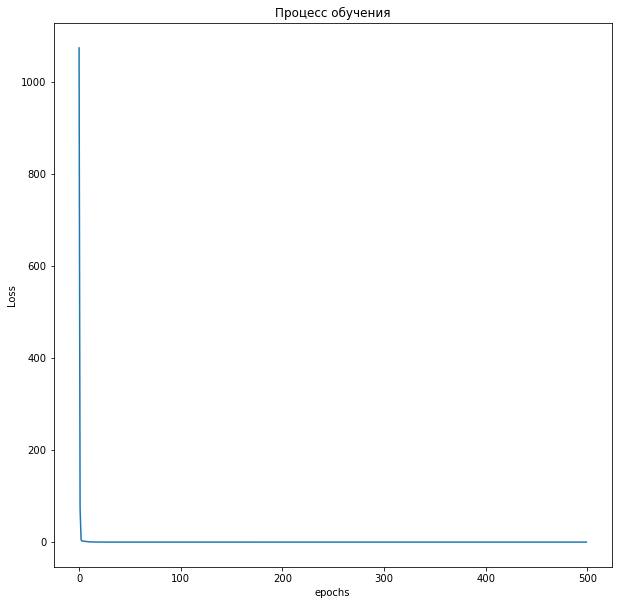

In [35]:
plt.plot(np.array(mses))
plt.title('Процесс обучения')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.show()

Протестируем сеть на тестовом подмножестве.

In [36]:
preds = np.array([predict(rbf, train_T), predict(rbf, test_T)])
print("MSE on train data: ", multi_loss(preds[0], train_X))
print("MSE on test data: ", multi_loss(preds[1], test_X))

MSE on train data:  0.008635812891865208
MSE on test data:  0.16448612098666146


Визуализация результатов.

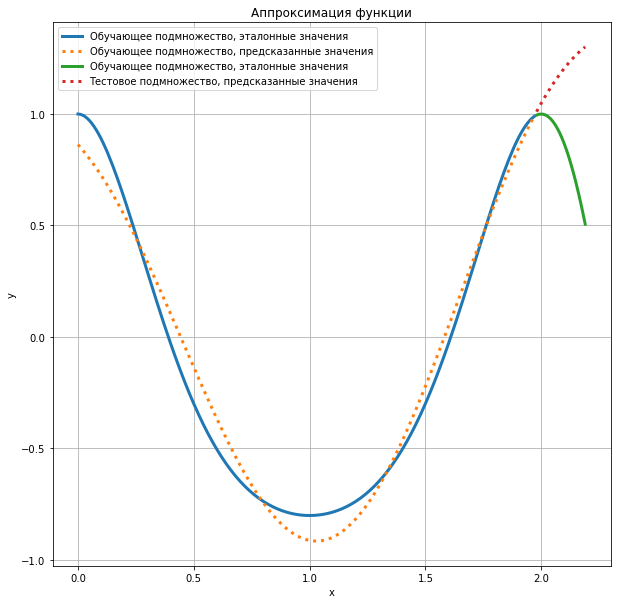

In [37]:
plt.plot(train_T, train_X, linewidth=3)
plt.plot(train_T, preds[0], linestyle=':', linewidth=3)

plt.plot(test_T, test_X, linewidth=3)
plt.plot(test_T, preds[1], linestyle=':', linewidth=3)

plt.title('Аппроксимация функции')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Обучающее подмножество, эталонные значения', 'Обучающее подмножество, предсказанные значения',
            'Обучающее подмножество, эталонные значения', 'Тестовое подмножество, предсказанные значения'])
plt.grid()
plt.show()

По графику видно, что модель неверно аппроксимирует функцию на тех данных, на которых она не обучалась. Т.к. мы сформировали тестовое подмножество с конца, соответственно, сеть не обучалась на том интервале, на котором находятся эти точки.

# Тестирование модели на рыхлых данных

Для тестирования модели на рыхлых данных сформируем обучающее множество следующим образом. Перемешаем все точки и разделим рандомным образом на обучающее и тестовое подножества в соотношении 80 и 20%.

In [38]:
np.random.shuffle(T)
T = T[:100]

train_T, test_T = np.array_split(T, [ int( 0.8 * np.shape(T)[0])])
train_X, test_X = x(train_T), x(test_T)

Визуализация рыхлых данных.

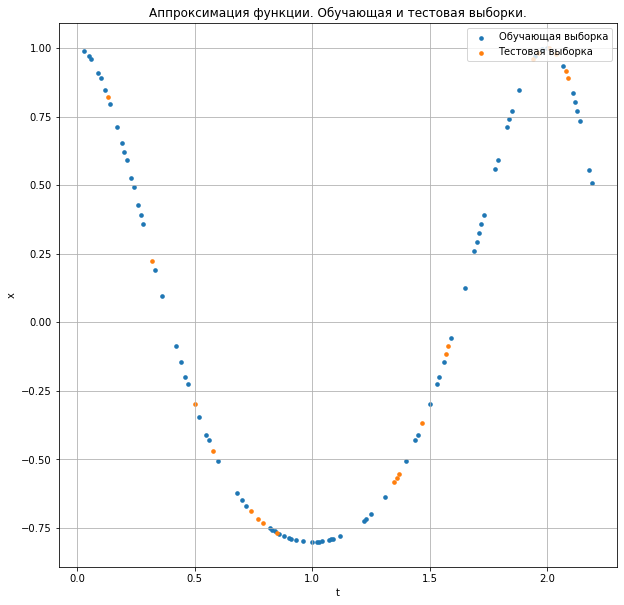

In [39]:
plt.scatter(train_T, train_X, linewidth=2, s=7)
plt.scatter(test_T, test_X, linewidth=2, s=7)

plt.title('Аппроксимация функции. Обучающая и тестовая выборки.')
plt.ylabel('x')
plt.xlabel('t')
plt.legend(['Обучающая выборка', 'Тестовая выборка'], loc='upper right')
plt.grid()
plt.show()

Обучим модель на рыхлых данных.

In [40]:
n1 = np.shape(T)[0]
n2 = 1
rbf2 = RBF(n1, n2, T)

In [41]:
dist = np.array([gaussian(dist_count(t, rbf2.weights[0])) for t in train_T])
mses = multi_train(rbf2, dist, train_T, train_X, 1e-2, 500)
print("The model is trained!")

Epoch:  1  mse:  0.07209108654904604
Epoch:  2  mse:  0.06814341546890831
Epoch:  3  mse:  0.06510330947980292
Epoch:  4  mse:  0.06246970026626077
Epoch:  5  mse:  0.06007405941731629
Epoch:  6  mse:  0.05784524604743106
Epoch:  7  mse:  0.05574916289512819
Epoch:  8  mse:  0.05376719906678005
Epoch:  9  mse:  0.05188782032006354
Epoch:  10  mse:  0.05010298556763224
Epoch:  11  mse:  0.04840649946303353
Epoch:  12  mse:  0.0467932100687008
Epoch:  13  mse:  0.04525860149335874
Epoch:  14  mse:  0.04379858033677947
Epoch:  15  mse:  0.04240936032078678
Epoch:  16  mse:  0.04108739769711666
Epoch:  17  mse:  0.03982935329402818
Epoch:  18  mse:  0.03863206871345608
Epoch:  19  mse:  0.03749255015476791
Epoch:  20  mse:  0.03640795643523144
Epoch:  21  mse:  0.035375589394701104
Epoch:  22  mse:  0.034392885721331715
Epoch:  23  mse:  0.03345740968237536
Epoch:  24  mse:  0.03256684648014324
Epoch:  25  mse:  0.03171899607805312
Epoch:  26  mse:  0.03091176740790589
Epoch:  27  mse:  0.

In [42]:
preds = np.array([predict(rbf2, train_T), predict(rbf2, test_T)])
print("MSE on train data: ", multi_loss(preds[0], train_X))
print("MSE on test data: ", multi_loss(preds[1], test_X))

MSE on train data:  0.013998150104026585
MSE on test data:  0.023168867430934804


Визуализация результатов.

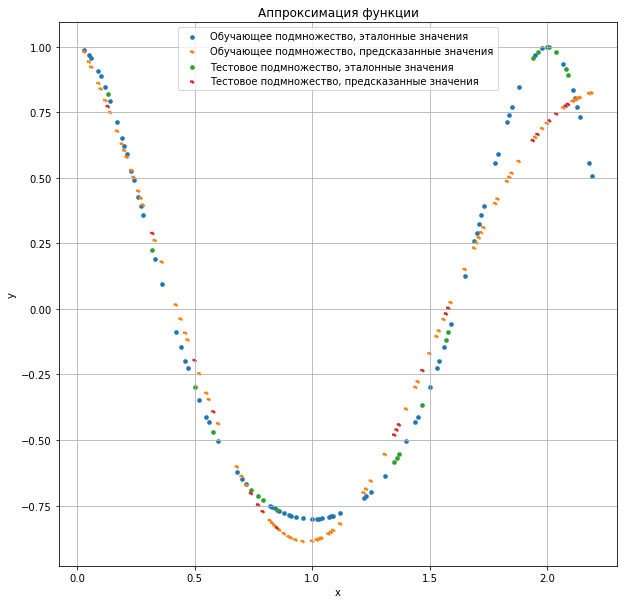

In [43]:
plt.scatter(train_T, train_X, linewidth=2, s=7)
plt.scatter(train_T, preds[0], linestyle=':', linewidth=2, s=7)

plt.scatter(test_T, test_X, linewidth=2, s=7)
plt.scatter(test_T, preds[1], linestyle=':', linewidth=2, s=7)

plt.title('Аппроксимация функции')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Обучающее подмножество, эталонные значения', 'Обучающее подмножество, предсказанные значения',
            'Тестовое подмножество, эталонные значения', 'Тестовое подмножество, предсказанные значения'])
plt.grid()
plt.show()

На рыхлых данных сеть неплохо аппроксимирует функцию.